In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
from numpy import vstack
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
sns.set()
%matplotlib inline
plt.ion() #Turn the interactive mode on
torch.manual_seed(42);   # reproducible

# Training Neural Networks

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="figures/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src'figures/gradient_descent.png' width=350px>

## Backpropagation

For single layer networks, gradient descent is simple to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks, although it's straightforward once you learn about it. 

This is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='figures/w1_backprop_graph.png' width=400px>

In the forward pass through the network, our data and operations go from right to left here. To train the weights with gradient descent, we propagate the gradient of the cost backwards through the network. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\frac{\partial \ell}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial \ell}{\partial l_2}
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
w^\prime = w - \alpha \frac{\partial \ell}{\partial w}
$$

The learning rate is set such that the weight update steps are small enough that the iterative method settles in a minimum.

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

## Autograd

Torch provides a module, `autograd`, for automatically calculating the gradient of tensors. It does this by keeping track of operations performed on tensors. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [7]:
x = torch.tensor([[1,2],[3,4]], requires_grad=True, dtype=torch.float32)

In [8]:
print(x)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


In [9]:
y = x- 2
print(y)

tensor([[-1.,  0.],
        [ 1.,  2.]], grad_fn=<SubBackward0>)


In [10]:
z = y*y*3
a = z.mean()
print(z)
print(a)

tensor([[ 3.,  0.],
        [ 3., 12.]], grad_fn=<MulBackward0>)
tensor(4.5000, grad_fn=<MeanBackward0>)


In [11]:
with torch.no_grad():
    b = x*2
    print(b.requires_grad)

False


In [12]:
# activation functions
x = torch.linspace(-10,10,1500)
x = Variable(x)
print(x)

tensor([-10.0000,  -9.9867,  -9.9733,  ...,   9.9733,   9.9867,  10.0000])


In [13]:
x1 = x.data.numpy()
relu = F.relu(x).data.numpy()
sigmoid = torch.sigmoid(x).data.numpy()
tanh = torch.tanh(x).data.numpy()
softplus = F.softplus(x).data.numpy()

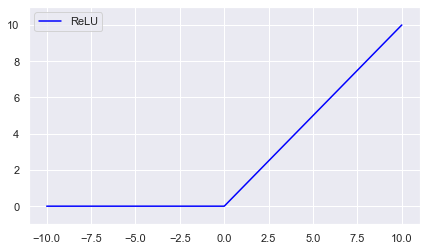

In [14]:
plt.figure(figsize=(7,4))
plt.plot(x1, relu,c='blue',label='ReLU')
plt.ylim(-1,11)
plt.legend(loc='best');
plt.show();

In [15]:
#ReLU(x) = max(0,x)
relu = nn.ReLU()
tensor1 = torch.tensor([2.0,-4.0])
print(relu(tensor1))
tensor2 = torch.tensor([[2.0, -4.],[1.2, 0.]])
print(relu(tensor2))

tensor([2., 0.])
tensor([[2.0000, 0.0000],
        [1.2000, 0.0000]])


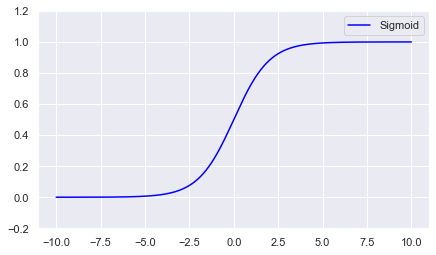

In [13]:

plt.figure(figsize=(7,4))
plt.plot(x1, sigmoid,c='blue',label='Sigmoid')
plt.ylim((-0.2, 1.2))
plt.legend(loc='best');
plt.show();

In [16]:
sigmoid = nn.Sigmoid()
tensor1 = torch.tensor([2.0,-4.0])
print(sigmoid(tensor1))
tensor2 = torch.tensor([[2.0, -4.],[1.2, 0.]])
print(sigmoid(tensor2))

tensor([0.8808, 0.0180])
tensor([[0.8808, 0.0180],
        [0.7685, 0.5000]])


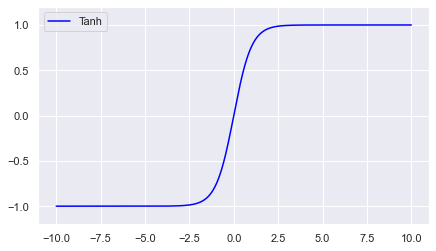

In [16]:
plt.figure(figsize=(7,4))
plt.plot(x1, tanh,c='blue',label='Tanh')
plt.ylim((-1.2, 1.2))
plt.legend(loc='best');
plt.show();

In [25]:
tanh = torch.tanh
tensor1 = torch.tensor([2.0,-4.0])
print(tanh(tensor1))
tensor2 = torch.tensor([[2.0, -4.],[1.2, 0.]])
print(tanh(tensor2))

tensor([ 0.9640, -0.9993])
tensor([[ 0.9640, -0.9993],
        [ 0.8337,  0.0000]])


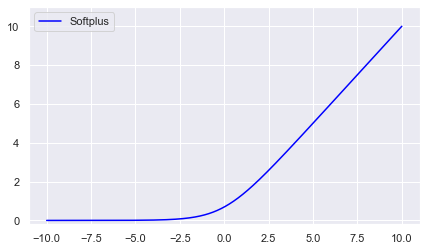

In [17]:
plt.figure(figsize=(7,4))
plt.plot(x1, softplus,c='blue',label='Softplus')
plt.ylim(-0.2,11)
plt.legend(loc='best');
plt.show();

In [23]:
softplus = F.softplus
tensor1 = torch.tensor([2.0,-4.0])
print(softplus(tensor1))
tensor2 = torch.tensor([[2.0, -4.],[1.2, 0.]])
print(softplus(tensor2))

tensor([2.1269, 0.0181])
tensor([[2.1269, 0.0181],
        [1.4633, 0.6931]])


In [18]:
url = "https://raw.githubusercontent.com/mesfind/datasets/master/mtcars.csv"
df = pd.read_csv(url)
df.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,fast,cars,carname
0,4.582576,6,160.0,110,3.90,2.620,16.46,0,1,4,4,1,Mazda RX4,Mazda RX4
1,4.582576,6,160.0,110,3.90,2.875,17.02,0,1,4,4,1,Mazda RX4 Wag,Mazda RX4 Wag
2,4.774935,4,108.0,93,3.85,2.320,18.61,1,1,4,1,1,Datsun 710,Datsun 710
3,4.626013,6,258.0,110,3.08,3.215,19.44,1,0,3,1,1,Hornet 4 Drive,Hornet 4 Drive
4,4.324350,8,360.0,175,3.15,3.440,17.02,0,0,3,2,1,Hornet Sportabout,Hornet Sportabout


In [19]:
x = torch.unsqueeze(torch.from_numpy(np.array(df.qsec)), dim=1)
y = torch.unsqueeze(torch.from_numpy(np.array(df.mpg)), dim=1)

In [20]:
x[0:10]

tensor([[16.4600],
        [17.0200],
        [18.6100],
        [19.4400],
        [17.0200],
        [20.2200],
        [15.8400],
        [20.0000],
        [22.9000],
        [18.3000]], dtype=torch.float64)

In [21]:
y[0:10]

tensor([[4.5826],
        [4.5826],
        [4.7749],
        [4.6260],
        [4.3243],
        [4.2544],
        [3.7815],
        [4.9396],
        [4.7749],
        [4.3818]], dtype=torch.float64)

In [26]:
class Net(nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(Net,self).__init__()
        self.hidden = nn.Linear(n_features, n_hidden)
        self.predict = nn.Linear(n_hidden, n_output)
    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.predict(x)
        return x

In [27]:
net = Net(n_features=1, n_hidden=20, n_output=1)
net.double()
print(net)

Net(
  (hidden): Linear(in_features=1, out_features=20, bias=True)
  (predict): Linear(in_features=20, out_features=1, bias=True)
)


In [28]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.2
    momentum: 0
    nesterov: False
    weight_decay: 0
)


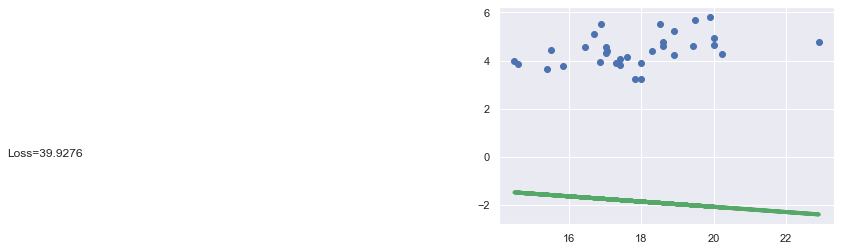

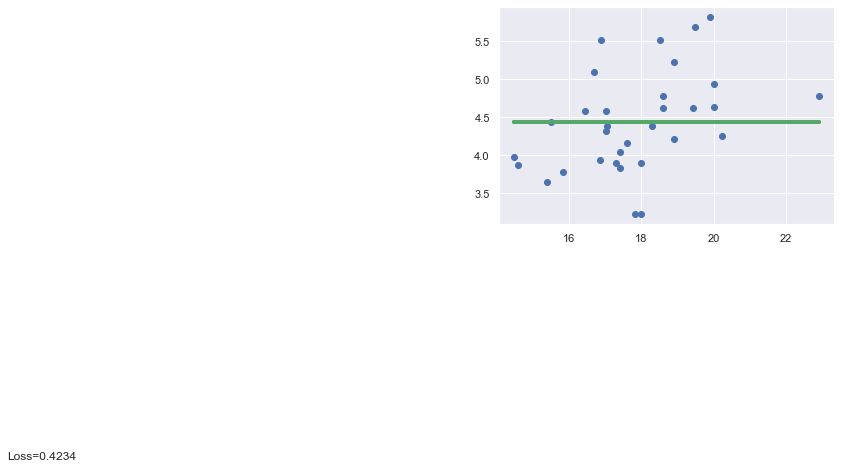

In [29]:
for t in range(100):
    y_pred = net(x)
    loss = loss_func(y_pred,y)
    optimizer.zero_grad() # clear the gradient for the next train
    loss.backward() # compute gradient
    optimizer.step() # apply gradient
    
    if t % 50 == 0:
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(),y_pred.data.numpy(),'g-', lw=4)
        plt.text(0.5, 0, 'Loss=%.4f'%loss.data.numpy())
        plt.show()
    plt.ioff()

Besides theoretical issues, the absence of sufficient computing power also meant that neural networks could not be utilized massively. Decades later, technological progress made possible the growth into multilayer perceptrons, or MLPs. In these perceptrons, more than just one neuron is used for generating predictions. In addition, neurons are stacked in layers of increasing abstractness, where each layers learns more abstract patterns. That is, while one layer can learn to detect lines, another can learn to detect noses.

In MLPs, the input data is fed to an input layer that shares the dimensionality of the input space. For example, if you feed input samples with 8 features per sample, you’ll also have 8 neurons in the input layer. After being processed by the input layer, the results are passed to the next layer, which is called a hidden layer. The final layer is an output. Its neuron structure depends on the problem you are trying to solve (i.e. one neuron in the case of regression and binary classification problems; multiple neurons in a multiclass classification problem).

We can use standard Python libraries to load and prepare tabular data, like CSV files. For example, Pandas can be used to load your CSV file, and tools from scikit-learn can be used to encode categorical data, such as class labels.

In [60]:
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path):
        df = pd.read_csv(path, header=None)
        # store the inputs and outputs
        self.X = df.values[:,:-1]
        self.y = df.values[:,-1]
        # ensure input data is floats
        self.X = self.X.astype('float32')
        self.y = LabelEncoder().fit_transform(self.y) # for catergorical labels
        self.y = self.y.astype('float32')
        self.y = self.y.reshape(len(self.y),1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
    def get_splits(self, n_test=0.33):
        test_size = round(n_test*len(self.X))
        trian_size = len(self.X) - test_size
        return random_split(self, [trian_size,test_size])

In [61]:
def prepare_data(path):
    dataset = CSVDataset(path)
    train, test = dataset.get_splits()
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl =  DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, test_dl

In [62]:
def train_model(train_dl, test_dl):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    for epoch in range(100):
        for i, (inputs, targets) in enumerate(train_dl):
            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = criterion(y_pred, targets)
            loss.backward()
            optimizer.step()

In [83]:
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        y_pred = model(inputs)
        y_pred = y_pred.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual),1))
        y_pred = y_pred.round()
        predictions.append(y_pred)
        actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    acc = accuracy_score(actuals, predictions)
    return acc

In [64]:
def predict(row, model):
    row = torch.Tensor([row])
    y_pred = model(row)
    y_pred = y_pred.detach().numpy()
    return y_pred

In [65]:
# prepare the data
path = 'https://raw.githubusercontent.com/mesfind/datasets/master/Ionosphere.csv'
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))

235 116


In [100]:
class MLP(nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(MLP,self).__init__()
        self.hidden1 = nn.Linear(n_features, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.predict = nn.Linear(n_hidden, n_output)
    def forward(self, x):
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.predict(x)
        x = torch.sigmoid(x)
        return x

In [101]:
model =   MLP(34, 10,1)

In [102]:
train_model(train_dl, model)

In [103]:
acc = evaluate_model(test_dl, model)
print('Accuracy: %3.f'%acc)

Accuracy:   1


In [104]:
# make a single prediction (expect class=1)
row = [1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1,0.03760,0.85243,
       -0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,
       -0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,
       -0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300]
y_pred = predict(row, model)
print('Predicted: %.3f (class=%d)' % (y_pred, y_pred.round()))

Predicted: 0.996 (class=1)


In [ ]:
## Convolution

In [105]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [108]:
# MNIST dataset
import torchvision
import torchvision.transforms as transforms
train_dataset = torchvision.datasets.MNIST(root='../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

/Users/admin/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [109]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [110]:
model = ConvNet(num_classes).to(device)

In [111]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [112]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


/Users/admin/miniconda3/envs/torch/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/5], Step [100/600], Loss: 0.1157
Epoch [1/5], Step [200/600], Loss: 0.0640
Epoch [1/5], Step [300/600], Loss: 0.0452
Epoch [1/5], Step [400/600], Loss: 0.0142
Epoch [1/5], Step [500/600], Loss: 0.0798
Epoch [1/5], Step [600/600], Loss: 0.0369
Epoch [2/5], Step [100/600], Loss: 0.0146
Epoch [2/5], Step [200/600], Loss: 0.0982
Epoch [2/5], Step [300/600], Loss: 0.0745
Epoch [2/5], Step [400/600], Loss: 0.0717
Epoch [2/5], Step [500/600], Loss: 0.0305
Epoch [2/5], Step [600/600], Loss: 0.0910
Epoch [3/5], Step [100/600], Loss: 0.0299
Epoch [3/5], Step [200/600], Loss: 0.0220
Epoch [3/5], Step [300/600], Loss: 0.0117
Epoch [3/5], Step [400/600], Loss: 0.0258
Epoch [3/5], Step [500/600], Loss: 0.0707
Epoch [3/5], Step [600/600], Loss: 0.0693
Epoch [4/5], Step [100/600], Loss: 0.0126
Epoch [4/5], Step [200/600], Loss: 0.0512
Epoch [4/5], Step [300/600], Loss: 0.0523
Epoch [4/5], Step [400/600], Loss: 0.0625
Epoch [4/5], Step [500/600], Loss: 0.0064
Epoch [4/5], Step [600/600], Loss:

In [113]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 98.74 %


In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

In [117]:
# Hyper Parameters
EPOCH = 1               
# train the input data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
# 50 samples at a time to pass through the epoch
LR = 0.001              
# learning rate
DOWNLOAD_MNIST = True   
# set to False if you have downloaded

In [118]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     
    # this is training data
    transform=torchvision.transforms.ToTensor(),    
    # torch.FloatTensor of shape (Color x Height x Width) and 
    #normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        
    # download it if you don't have it
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [120]:
# Data Loader for easy mini-batch return in training, the image batch shape will be 
#(50, 1, 28, 28)
train_loader =DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(torch.FloatTensor)[:2000]/255.   
# shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]

/Users/admin/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/admin/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [114]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  
                # if want same width and length of this image after con2d, 
                #padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    
            # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [115]:
cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [122]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

Epoch:  0 | train loss: 2.3099 | test accuracy: 0.20


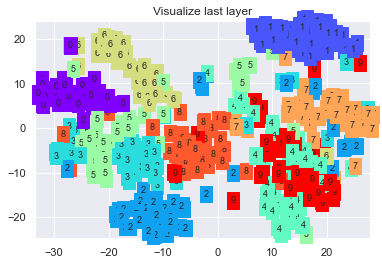

Epoch:  0 | train loss: 0.2194 | test accuracy: 0.89


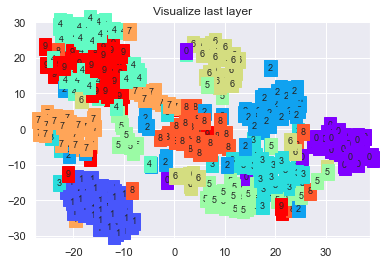

Epoch:  0 | train loss: 0.0879 | test accuracy: 0.93


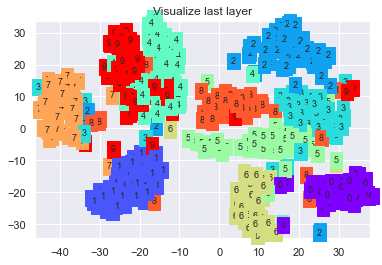

Epoch:  0 | train loss: 0.0949 | test accuracy: 0.95


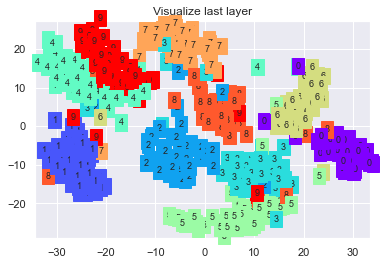

Epoch:  0 | train loss: 0.1133 | test accuracy: 0.95


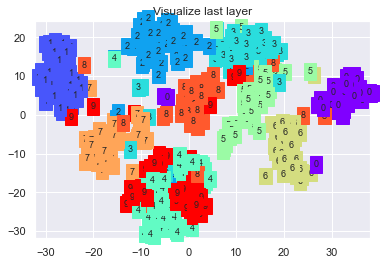

Epoch:  0 | train loss: 0.0617 | test accuracy: 0.96


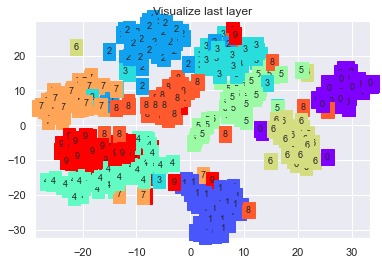

Epoch:  0 | train loss: 0.0113 | test accuracy: 0.97


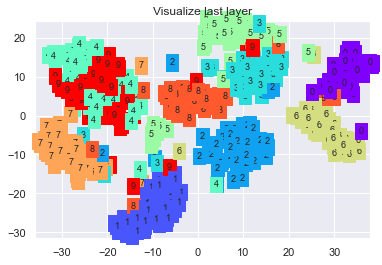

Epoch:  0 | train loss: 0.1277 | test accuracy: 0.97


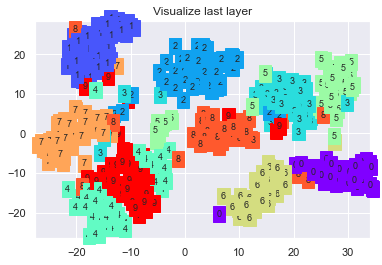

Epoch:  0 | train loss: 0.0869 | test accuracy: 0.96


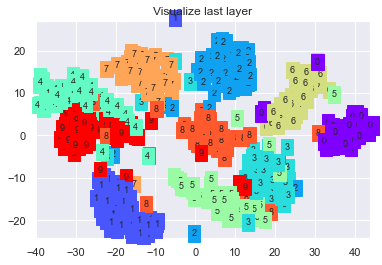

Epoch:  0 | train loss: 0.0151 | test accuracy: 0.97


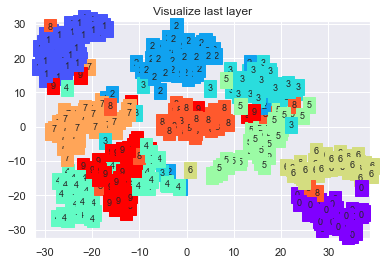

Epoch:  0 | train loss: 0.0164 | test accuracy: 0.97


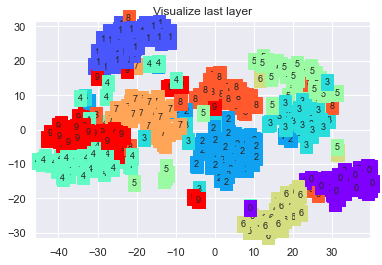

Epoch:  0 | train loss: 0.1410 | test accuracy: 0.97


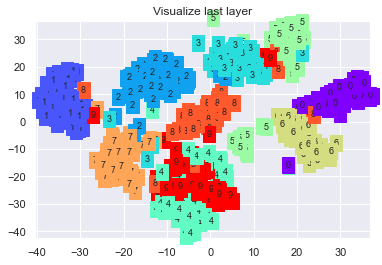

In [123]:
from matplotlib import cm
try:
    from sklearn.manifold import TSNE; HAS_SK = True
except:
    HAS_SK = False
    print('Please install sklearn for layer visualization, if not there')
    
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer');
    plt.show(); 
    #plt.pause(0.01)

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   
        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), 
                  '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()